# Prediction and performance metrics
## Notebook for running predictions

In [80]:
import json
import pandas as pd
import boto3

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sn

In [81]:
sagemaker_client = boto3.client("sagemaker-runtime")
s3_client = boto3.client('s3', region_name=boto3.Session().region_name)

#to fix - hardcoded
proj_bucket = "nikhil-spam-ham"
endpoint_name = "blazingtext-2022-10-26-23-32-03-964"


response = s3_client.get_object(Bucket=proj_bucket, Key="test/test.csv")
status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")

if status == 200:
    print(f"Successful S3 get_object response. Status - {status}")
    test_emails = pd.read_csv(response.get("Body"), header=None)
    test_emails.columns = ['test.message_bzt']
else:
    print(f"Unsuccessful S3 get_object response. Status - {status}")

#test_emails=test_emails.head(10)
#Spliting test messages to remove blazing text label prefix
temp_df = test_emails["test.message_bzt"].str.split(".0 subject ", n = 1, expand = True)

test_emails["test.spam_label"] = temp_df[0].apply(lambda x: (x[9:12] + ".0"))
test_emails["test.message"] = temp_df[1]
test_emails.head()

Successful S3 get_object response. Status - 200


,test.message_bzt,test.spam_label,test.message
0,__label__1.0 subject 79 hfi pharmaaccy hello t...,1.0,79 hfi pharmaaccy hello try pharrmabymail shop...
1,__label__0.0 subject request amendment oneok e...,0.0,request amendment oneok energy marketing tradi...
2,__label__1.0 subject gouranga gouranga happy g...,1.0,gouranga gouranga happy gouranga gouranga gour...
3,__label__1.0 subject cla ` ll | | s iev ` iltr...,1.0,cla ` ll | | s iev ` iltra l ant | | mpo 0 ten...
4,__label__1.0 subject www mediccation hello wel...,1.0,www mediccation hello welcome good online stor...


In [82]:
#send payload to endpoint
payload = {"instances" : test_emails['test.message'].to_numpy().tolist() }

predection_response = sagemaker_client.invoke_endpoint(EndpointName=endpoint_name,Body=json.dumps(payload), ContentType='application/json')

#Convert response to dataframe
predection_response_body = predection_response['Body'].read().decode('utf-8')
predection_response_body_raw = json.loads(predection_response_body)
request_and_prediction = list(zip(payload['instances'],predection_response_body_raw))
request_and_prediction_df = pd.DataFrame(request_and_prediction, columns = ['pred.message','pred.prediction_raw'])

#concatinate test and prediction datasets on columns to compare
temp_df = pd.json_normalize(predection_response_body_raw)
pretty_request_and_prediction_df = pd.concat([request_and_prediction_df, df2, test_emails], axis=1)
pretty_request_and_prediction_df['pred.spam_label'] = pretty_request_and_prediction_df['label'].apply(lambda x: x[0][9:12])

#Dropping columns
#'pred.message','pred.prediction_raw','label','prob','testmessage_bzt','test.spam_label','test.message','pred.spam_label'
pretty_request_and_prediction_df = pretty_request_and_prediction_df[['test.spam_label','test.message','pred.spam_label','pred.message']]
pretty_request_and_prediction_df.head()


,test.spam_label,test.message,pred.spam_label,pred.message
0,1.0,79 hfi pharmaaccy hello try pharrmabymail shop...,1.0,79 hfi pharmaaccy hello try pharrmabymail shop...
1,0.0,request amendment oneok energy marketing tradi...,0.0,request amendment oneok energy marketing tradi...
2,1.0,gouranga gouranga happy gouranga gouranga gour...,1.0,gouranga gouranga happy gouranga gouranga gour...
3,1.0,cla ` ll | | s iev ` iltra l ant | | mpo 0 ten...,1.0,cla ` ll | | s iev ` iltra l ant | | mpo 0 ten...
4,1.0,www mediccation hello welcome good online stor...,1.0,www mediccation hello welcome good online stor...


              precision    recall  f1-score   support

         ham       0.98      0.96      0.97       854
        spam       0.99      0.99      0.99      2518

    accuracy                           0.99      3372
   macro avg       0.99      0.98      0.98      3372
weighted avg       0.99      0.99      0.99      3372



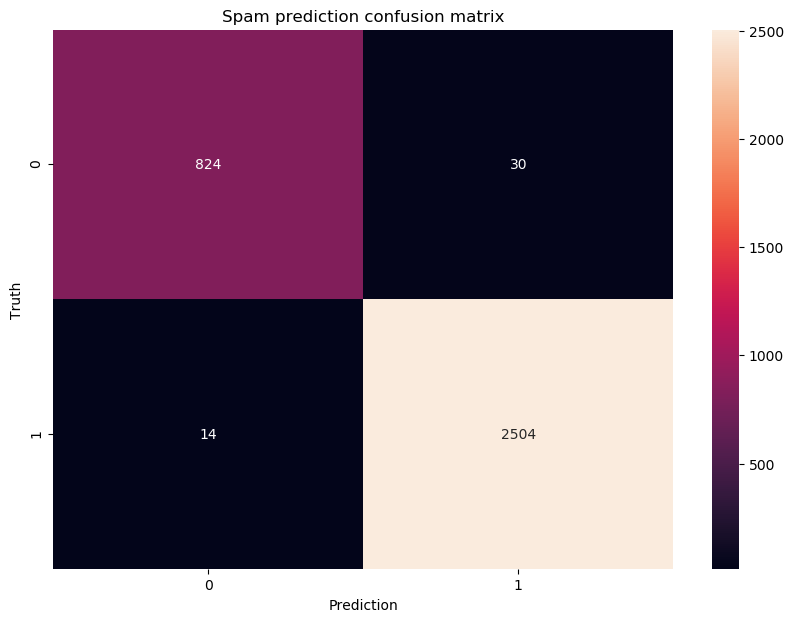

In [83]:
print(classification_report(pretty_request_and_prediction_df['test.spam_label'], pretty_request_and_prediction_df['pred.spam_label'], target_names=['ham','spam']))

cm = confusion_matrix(pretty_request_and_prediction_df['test.spam_label'], pretty_request_and_prediction_df['pred.spam_label'])
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d').set(title='Spam prediction confusion matrix')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()